In [1]:
!pip install pyspark matplotlib tqdm tabulate


In [1]:
import torch
print("💻 使用裝置：", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


💻 使用裝置： cuda


In [5]:
from pyspark.sql import SparkSession

# 啟動 Spark，多核心模式（local[*] = 所有核心）
spark = SparkSession.builder \
    .appName("Show Columns with Spark") \
    .master("local[*]") \
    .getOrCreate()

# 讀取 CSV 檔案
file_path = "/content/drive/MyDrive/Colab Notebooks/HI-Large_Trans.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 顯示欄位名稱
print("📌 資料欄位名稱如下：")
for col in df.columns:
    print(f" - {col}")

# 若你還想看前幾筆
print("\n📊 前五筆資料：")
df.show(5)

# 結束 Spark（選擇性）
spark.stop()


📌 資料欄位名稱如下：
 - Timestamp
 - From Bank
 - Account2
 - To Bank
 - Account4
 - Amount Received
 - Receiving Currency
 - Amount Paid
 - Payment Currency
 - Payment Format
 - Is Laundering

📊 前五筆資料：
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/08/01 00:17|       20|800104D70|     20|800104D70|        6794.63|         US Dollar|    6794.63|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:02|     3196|800107150|   3196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:17|     1208|80010E430|   1208|80010E430|

In [1]:
!pip install -U -q cudf-cu11 dask-cudf --extra-index-url=https://pypi.ngc.nvidia.com


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement dask-cudf (from versions: none)
ERROR: No matching distribution found for dask-cudf


In [4]:
import pandas as pd
import cudf

def load_data_cudf_safely(
    filepath: str,
    usecols: list = ["Amount Received", "Amount Paid", "Is Laundering"],
    nrows: int = 100_000
) -> cudf.DataFrame:
    """
    安全載入大型 CSV 並轉成 cuDF DataFrame（支援 CUDA 加速）

    參數：
    - filepath: CSV 檔案路徑
    - usecols: 要讀取的欄位清單
    - nrows: 只讀前 nrows 筆資料，防止 GPU 爆掉

    回傳：
    - cuDF 的 GPU DataFrame
    """
    print(f"📥 讀取中（最多 {nrows} 筆）：{filepath}")
    df_pd = pd.read_csv(filepath, usecols=usecols, nrows=nrows)
    df_pd = df_pd.dropna()
    print(f"✅ pandas 載入完成（形狀：{df_pd.shape}），轉換為 cuDF...")

    df_cudf = cudf.DataFrame.from_pandas(df_pd)
    print(f"🚀 cuDF 載入完成（形狀：{df_cudf.shape}）✨")

    return df_cudf


In [5]:
# 📁 檔案路徑
file_path = "/content/drive/MyDrive/Colab Notebooks/HI-Large_Trans.csv"

# 🧠 安全載入並取得 cuDF 資料
df = load_data_cudf_safely(file_path)

# 🔍 檢查一下結果
print("\n📌 資料欄位：", list(df.columns))
print(df.head())


📥 讀取中（最多 100000 筆）：/content/drive/MyDrive/Colab Notebooks/HI-Large_Trans.csv
✅ pandas 載入完成（形狀：(100000, 3)），轉換為 cuDF...
🚀 cuDF 載入完成（形狀：(100000, 3)）✨

📌 資料欄位： ['Amount Received', 'Amount Paid', 'Is Laundering']
   Amount Received  Amount Paid  Is Laundering
0          6794.63      6794.63              0
1          7739.29      7739.29              0
2          1880.23      1880.23              0
3      73966883.00  73966883.00              0
4      45868454.00  45868454.00              0


In [6]:
import torch

def cudf_to_torch(df_cudf, device="cuda"):
    """
    將 cuDF DataFrame 轉換為 PyTorch Tensor

    傳入：
        df_cudf：cuDF 資料（包含特徵與標籤）
        device：'cuda' or 'cpu'

    回傳：
        X_tensor：特徵張量 (float32)
        y_tensor：標籤張量 (float32, shape: [n, 1])
    """
    X = df_cudf[["Amount Received", "Amount Paid"]].to_cupy()
    y = df_cudf["Is Laundering"].to_cupy()

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

    return X_tensor, y_tensor


In [7]:
X_tensor, y_tensor = cudf_to_torch(df, device="cuda")

print(f"🎯 特徵 tensor shape: {X_tensor.shape}")
print(f"🎯 標籤 tensor shape: {y_tensor.shape}")


🎯 特徵 tensor shape: torch.Size([100000, 2])
🎯 標籤 tensor shape: torch.Size([100000, 1])


In [9]:
from sklearn.model_selection import train_test_split

# 注意：這邊先從 GPU tensor 取回 CPU numpy 才能切分
X_np = X_tensor.cpu().numpy()
y_np = y_tensor.cpu().numpy()

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.3, random_state=42)

# 再轉回 GPU tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test, dtype=torch.float32).to(device)


先做邏輯迴歸

💻 使用裝置：cuda
📥 讀取中（最多 100000 筆）：/content/drive/MyDrive/Colab Notebooks/HI-Large_Trans.csv
🚀 cuDF 載入完成（形狀：(100000, 3)）

🔢 類別比例：陽性=0, 陰性=70000, 權重=1.00
🚀 開始訓練模型...


Training Epochs: 100%|██████████| 100/100 [00:00<00:00, 687.03it/s]



📊 測試集標籤分布： {np.float32(0.0): 29999, np.float32(1.0): 1}
🔮 模型預測分布： {np.float32(0.0): 30000}

🎯 模型評估結果：
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │       1 │
├───────────┼─────────┤
│ Precision │       0 │
├───────────┼─────────┤
│ Recall    │       0 │
├───────────┼─────────┤
│ F1-score  │       0 │
╘═══════════╧═════════╛


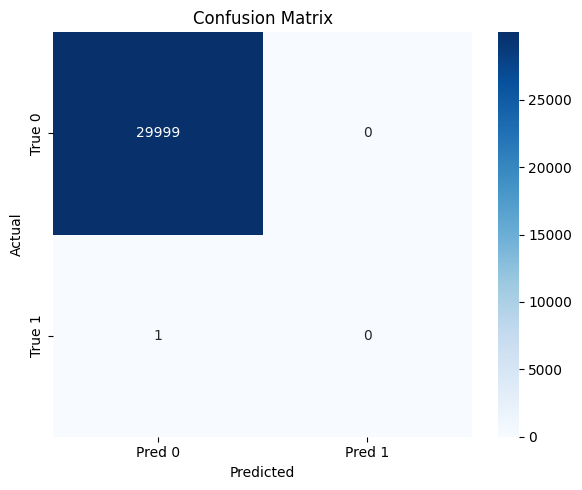

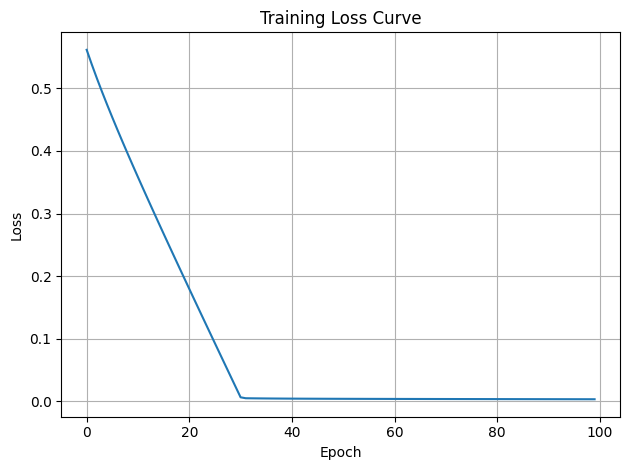

In [18]:
import pandas as pd
import cudf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# === 1. 設定裝置 === #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"💻 使用裝置：{device}")

# === 2. 安全讀取資料並轉換為 cuDF === #
def load_data_cudf_safely(filepath, usecols, nrows=100000):
    print(f"📥 讀取中（最多 {nrows} 筆）：{filepath}")
    df_pd = pd.read_csv(filepath, usecols=usecols, nrows=nrows).dropna()
    df_cudf = cudf.DataFrame.from_pandas(df_pd)
    print(f"🚀 cuDF 載入完成（形狀：{df_cudf.shape}）")
    return df_cudf

file_path = "/content/drive/MyDrive/Colab Notebooks/HI-Large_Trans.csv"
df = load_data_cudf_safely(file_path, ["Amount Received", "Amount Paid", "Is Laundering"])

# === 3. cuDF ➝ Torch Tensor（GPU）=== #
X = df[["Amount Received", "Amount Paid"]].to_cupy()
y = df["Is Laundering"].to_cupy()

# === 4. 切分資料（先轉 numpy 再轉 tensor）=== #
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).view(-1, 1).to(device)

# === 5. 建立 Logistic Regression 模型 === #
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
      return self.linear(x)  # ❌ 不加 sigmoid

model = LogisticRegressionModel().to(device)

# === 6. 計算類別比，設定 pos_weight === #
num_pos = torch.sum(y_train).item()
num_neg = y_train.shape[0] - num_pos
pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0], device=device)

# === 7. 訓練設定 === #
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
loss_history = []

print(f"\n🔢 類別比例：陽性={int(num_pos)}, 陰性={int(num_neg)}, 權重={pos_weight.item():.2f}")
print("🚀 開始訓練模型...")

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

# === 8. 評估模型 === #
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test)
    y_pred = (y_pred_prob >= 0.5).float()

# 回 CPU
y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()

# 統計
print("\n📊 測試集標籤分布：", dict(Counter(y_test_cpu.flatten())))
print("🔮 模型預測分布：", dict(Counter(y_pred_cpu.flatten())))

# 指標報告
report = classification_report(y_test_cpu, y_pred_cpu, output_dict=True, zero_division=0)
cm = confusion_matrix(y_test_cpu, y_pred_cpu)

# 防止 KeyError
precision = report['1']['precision'] if '1' in report else 0.0
recall    = report['1']['recall']    if '1' in report else 0.0
f1_score  = report['1']['f1-score']  if '1' in report else 0.0

metrics = [
    ["Accuracy",  f"{report['accuracy']:.4f}"],
    ["Precision", f"{precision:.4f}"],
    ["Recall",    f"{recall:.4f}"],
    ["F1-score",  f"{f1_score:.4f}"]
]

print("\n🎯 模型評估結果：")
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="fancy_grid"))

# === 9. 畫圖 === #
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
